In [1]:
import os
import requests
import numpy as np
import pandas as pd
import vextract.svg
import vextract.filter
import vextract.convert
import vextract.unwrap
import svgpathtools as spt
import matplotlib.pyplot as plt

from pathlib import Path

%matplotlib widget
%load_ext autoreload
%autoreload 2

In [2]:
# Import data extracted from R. P. Dias 2013 dissertation.

GeSe4_dict = {}

GeSe4_dict['13.5'] = pd.read_csv(
    '../data/extracted_data/GeSe4-FigB4/13p5_GPa.csv',
    names=('Temp', 'R'),
    skiprows=[0]
)

GeSe4_dict['16'] = pd.read_csv(
    '../data/extracted_data/GeSe4-FigB4/16_GPa.csv',
    names=('Temp', 'R'),
    skiprows=[0]
)

GeSe4_dict['24'] = pd.read_csv(
    '../data/extracted_data/GeSe4-FigB4/24_GPa.csv',
    names=('Temp', 'R'),
    skiprows=[0]
)

In [3]:
# For the MnS2 data, we need to download the article file.
# This is done so as not to supply copyrighted documents in my repository.
# This article is not open access - a subscription is required.

URL = "https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.127.016401"

if not Path('../data/source_data/PhysRevLett.127.016401.pdf').exists():
    print('Article file not found.  Attempting to download.')
    response = requests.get(URL)
    try:
        open('../data/source_data/PhysRevLett.127.016401.pdf', 'wb').write(response.content)
        print('Article successfully downloaded.')
    except OSError:
        print('Failed to download article.')
else:
    print('Article file found.')

Article file found.


In [4]:
# The un-edited paper: 
paper_file = '../data/source_data/PhysRevLett.127.016401.pdf'

# Location to store the svg version of the relevant page.
svg_page_file = '../data/svg_files/MnS2_page_2.svg'

# The page number on which the relavant figure is located.
page_number = 2

# Convert page of the paper into an svg file.
os.system(f'pdf2svg {paper_file} {svg_page_file} {page_number}')

# Load the svg file into memory.
# The resulting structure is a tuple of two lists.
# The first is a list of the path objects.
# The second is a list of the corresponding attributes.
svg = (
    # Convert color codes to hex for convenience.
    vextract.convert.hexify(
        # Apply transformation matrix that is inluded in svg attributes.
        vextract.convert.apply_tmatrix(
            # load the file in a tuple of paths and attributes.
            spt.svg2paths(svg_page_file))))

# Separate paths and attributes for convenience.
paths, attributes = svg

long_x = []
long_y = []
long_colors = []
for path, attribute in zip(paths, attributes):
    if len(path) > 30:
        if 'style' in attribute:
            style_dict = vextract.svg.style_string_to_dict(attribute['style'])
            if 'stroke' in style_dict:
                stroke = style_dict['stroke']
                if stroke not in ('none', '#000000'):
                    x, y = vextract.svg.path_starts(path)
                    long_x.append(x)
                    long_y.append(y)
                    long_colors.append(stroke)
                    
# Dictionary of data sets where key is the hex color code.
color_dict = {}
for x, y, color in zip(long_x, long_y, long_colors):
    df = pd.DataFrame()
    df['x'], df['y'] = x, y
    color_dict[color] = df

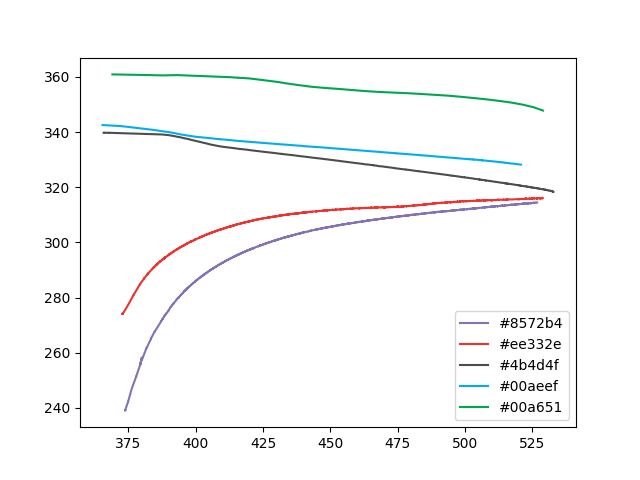

In [5]:
'''
Make a plot to see the color of each path so that we can figure
out the corresponding pressure.
'''

fig, ax = plt.subplots()
for color, df in color_dict.items():
    ax.plot(df.x, df.y, color=color, label=color)
    
ax.legend()

In [6]:
# Based on the above plot, we can figure out which color
# goes with which pressure.

legend = {
    '#00a651': '13',
    '#00aeef': '16',
    '#4b4d4f': '26',
    '#ee332e': '36',
    '#8572b4': '52'
}

In [7]:
# Create a dictionary of the MnS2 data, where pressure is the key
# the value is the corresponding dataframe.

MnS2_dict = {}
for color, df in color_dict.items():
    pressure = legend[color]
    MnS2_dict[pressure] = df

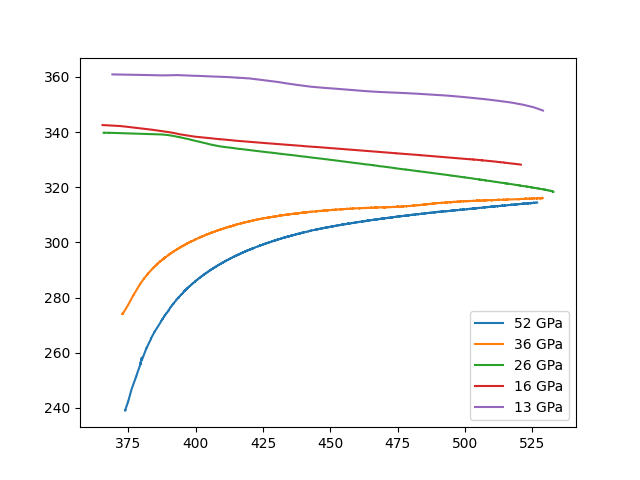

In [8]:
# Check work with a plot. 

fig, ax = plt.subplots()
for pressure, df in MnS2_dict.items():
    ax.plot(df.x, df.y, label=f'{pressure} GPa')
    
ax.legend()

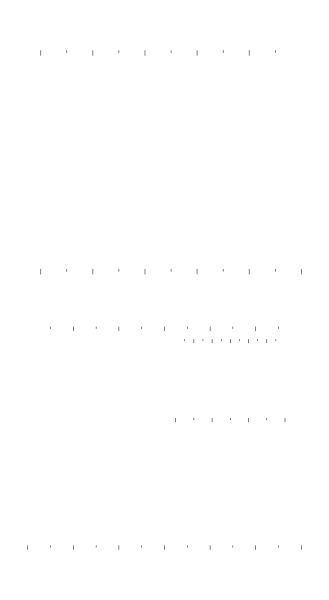

In [9]:
# Tic marks appear to be stored as horizontal and vertical lines.
# When using dark mode theme, it may be difficult to see the lines.
vextract.svg.display_svg(vextract.filter.by_vlines(svg))

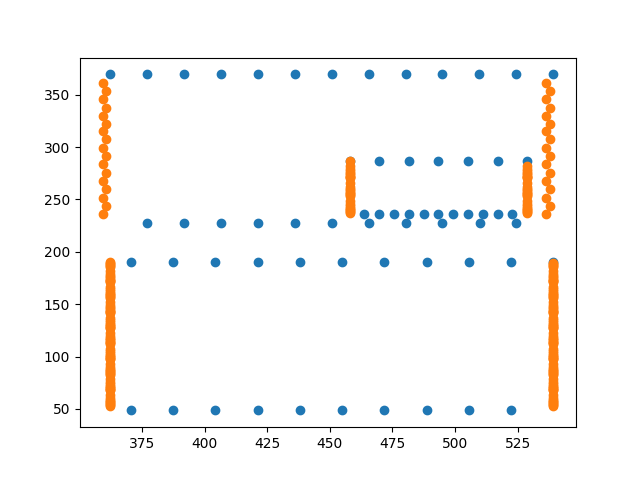

In [10]:
# Plot data to help figure out tic marks.
vpaths, _ = vextract.filter.by_vlines(svg)
hpaths, _ = vextract.filter.by_hlines(svg)
df_v = pd.DataFrame()
xs, ys = zip(*[vextract.svg.path_starts(path) for path in vpaths])
df_v['x'] = [x[0] for x in xs]
df_v['y'] = [y[0] for y in ys]

df_h = pd.DataFrame()
xs, ys = zip(*[vextract.svg.path_starts(path) for path in hpaths])
df_h['x'] = [x[0] for x in xs]
df_h['y'] = [y[0] for y in ys]

fig, ax = plt.subplots()
ax.scatter(df_v.x, df_v.y)
ax.scatter(df_h.x, df_h.y)

In [11]:
# These are the x locations (in svg units) of the lower x axis
# for Figure 1b
x_min = df_v[df_v.y > 300].x.min()
x_max = df_v[df_v.y > 300].x.max()

# Read from scale of plot.
T_min = 0
T_max = 300

print(f'{x_min = }, {x_max = }')

x_min = 362.11328125, x_max = 539.27734375


In [12]:
# Same thing for the x-axis
y_min = df_h[df_h.x < 360][df_h.y > 320].y.min()
y_max = df_h[df_h.x < 360][df_h.y > 320].y.max()

R_min = 2
R_max = 4

print(f'{y_min = }, {y_max = }')

y_min = 329.5859375, y_max = 361.44921875


/tmp/ipykernel_344711/3348820351.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_min = df_h[df_h.x < 360][df_h.y > 320].y.min()
/tmp/ipykernel_344711/3348820351.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y_max = df_h[df_h.x < 360][df_h.y > 320].y.max()


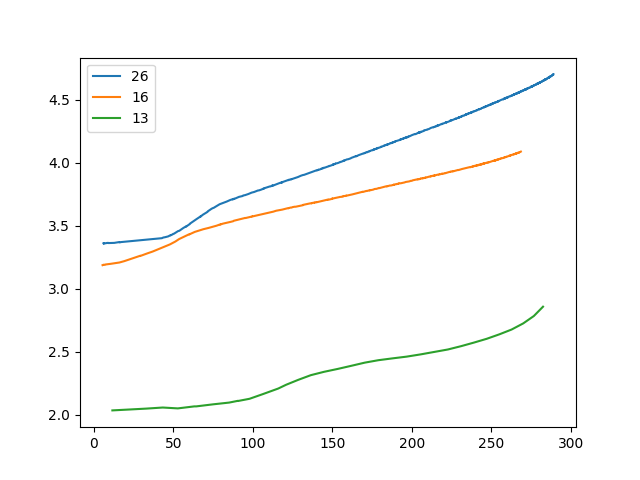

In [13]:
# Now we have the scale factors for both the x and y axes, so we can
# add columns to our data sets to represent properly scaled data.
# While we are at it, plot the data so we can see how it looks.

fig, ax = plt.subplots()
for pressure, df in MnS2_dict.items():
    if pressure not in ('52', '36'):
        df['R'] = df.y.apply(lambda R_arb: vextract.svg.transform_coord(y_min, y_max, R_max, R_min, R_arb))
        df['Temp'] = df.x.apply(lambda Temp_arb: vextract.svg.transform_coord(x_min, x_max, T_min, T_max, Temp_arb))    

        ax.plot(df.Temp, df.R, label=pressure)
    
ax.legend()

In [14]:
# Export the data to csv files.

for pressure in ['13', '16', '26']:
    df = MnS2_dict[pressure].copy()
    # We only want the Temp and R columns, not x and y
    df = df[['Temp', 'R']]
    # rename the columns for better labeling in the csv
    df.columns = ['Temperature(K)', 'Resistance(Ohms)']
    df.to_csv(
        f'../data/extracted_data/MnS2/{pressure}_GPa.csv',
        index=False
    )

# Two axis low T comparison

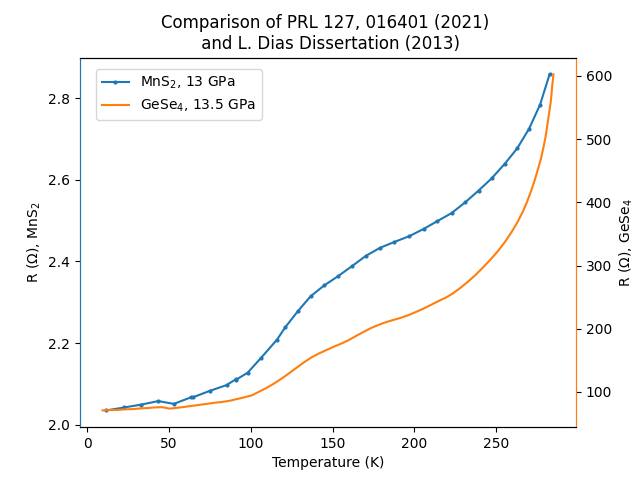

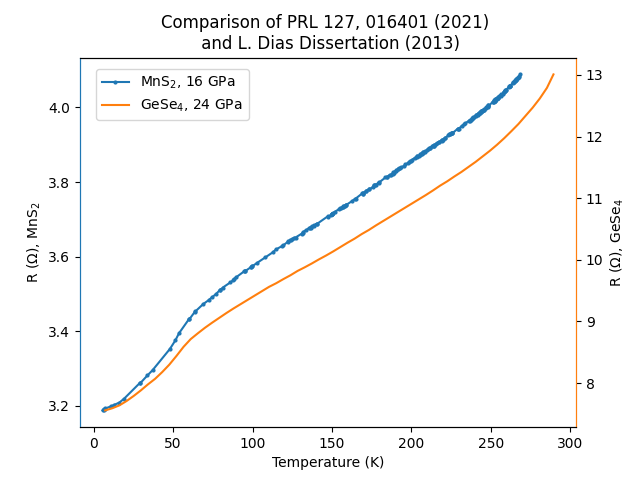

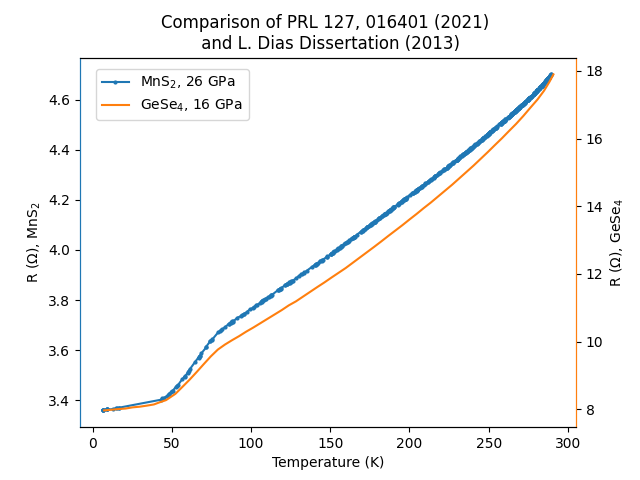

In [15]:
# Only plot data below this T
T_cutoff = 300

pairs = (
    ('13', '13.5'),
    ('16', '24'),
    ('26', '16')
)

for MnS2_pressure, GeSe4_pressure in pairs:
    fig, ax = plt.subplots()
    T = MnS2_dict[MnS2_pressure].Temp
    R = MnS2_dict[MnS2_pressure].R
    mask = T < T_cutoff
    ax.plot(
        T[mask],
        R[mask],
        '-o',
        markersize=2,
        label=f'MnS$_2$, {MnS2_pressure} GPa')

    ax2 = ax.twinx()

    T = GeSe4_dict[GeSe4_pressure].Temp
    R = GeSe4_dict[GeSe4_pressure].R
    mask = T < T_cutoff
    ax2.plot(
        T[mask],
        R[mask],
        color='tab:orange',
        label=f'GeSe$_4$, {GeSe4_pressure} GPa')

    ax.spines['left'].set_color('tab:blue')
    ax.spines['right'].set_color('tab:orange')
    # ax.yaxis.label.set_color('tab:blue')
    # ax.tick_params(axis='y', colors='tab:blue')
    
    ax2.spines['left'].set_color('tab:blue')
    ax2.spines['right'].set_color('tab:orange')
    # ax2.yaxis.label.set_color('tab:orange')
    # ax2.tick_params(axis='y', colors='tab:orange')

    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('R ($\Omega$), MnS$_2$')
    ax2.set_ylabel('R ($\Omega$), GeSe$_4$')
    fig.legend(loc=(0.15, 0.75))
    
    ax.set_title("Comparison of PRL 127, 016401 (2021) \n and L. Dias Dissertation (2013)")

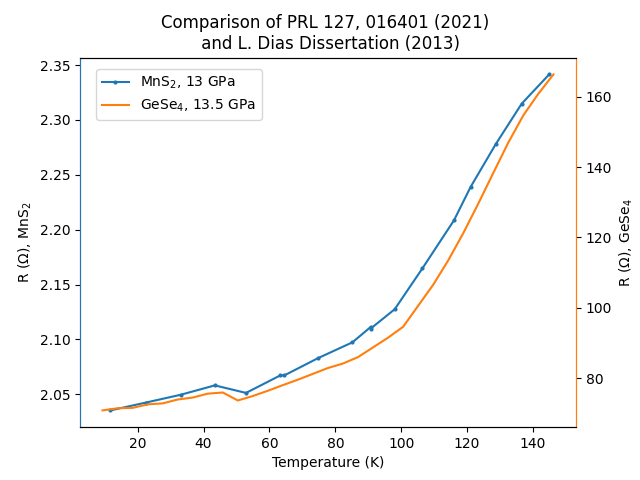

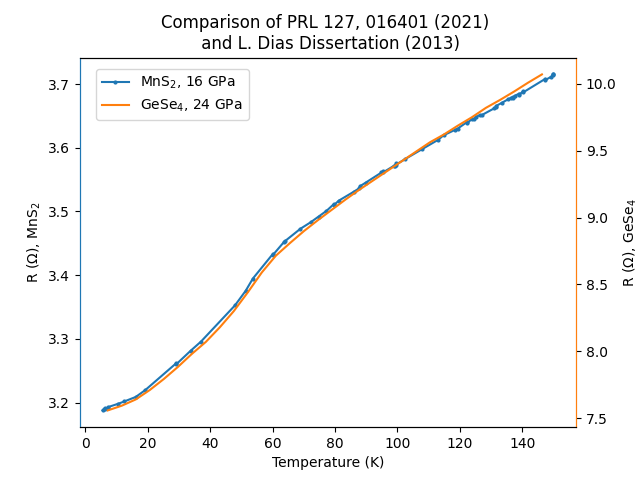

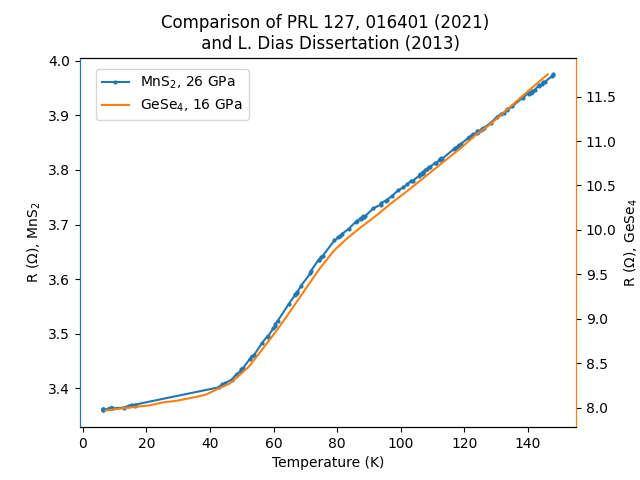

In [16]:
# Only plot data below this T
T_cutoff = 150

pairs = (
    ('13', '13.5'),
    ('16', '24'),
    ('26', '16')
)

for MnS2_pressure, GeSe4_pressure in pairs:
    fig, ax = plt.subplots()
    T = MnS2_dict[MnS2_pressure].Temp
    R = MnS2_dict[MnS2_pressure].R
    mask = T < T_cutoff
    ax.plot(
        T[mask],
        R[mask],
        '-o',
        markersize=2,
        label=f'MnS$_2$, {MnS2_pressure} GPa')

    ax2 = ax.twinx()

    T = GeSe4_dict[GeSe4_pressure].Temp
    R = GeSe4_dict[GeSe4_pressure].R
    mask = T < T_cutoff
    ax2.plot(
        T[mask],
        R[mask],
        color='tab:orange',
        label=f'GeSe$_4$, {GeSe4_pressure} GPa')

    ax.spines['left'].set_color('tab:blue')
    ax.spines['right'].set_color('tab:orange')
    # ax.yaxis.label.set_color('tab:blue')
    # ax.tick_params(axis='y', colors='tab:blue')
    
    ax2.spines['left'].set_color('tab:blue')
    ax2.spines['right'].set_color('tab:orange')
    # ax2.yaxis.label.set_color('tab:orange')
    # ax2.tick_params(axis='y', colors='tab:orange')

    ax.set_xlabel('Temperature (K)')
    ax.set_ylabel('R ($\Omega$), MnS$_2$')
    ax2.set_ylabel('R ($\Omega$), GeSe$_4$')
    fig.legend(loc=(0.15, 0.75))
    
    ax.set_title("Comparison of PRL 127, 016401 (2021) \n and L. Dias Dissertation (2013)")

For panel b:
Left y-axis limits: (2.0251317878631854, 2.2489886152261844)
Right y-axis limits: (68.29096268384589, 123.71280539686408)


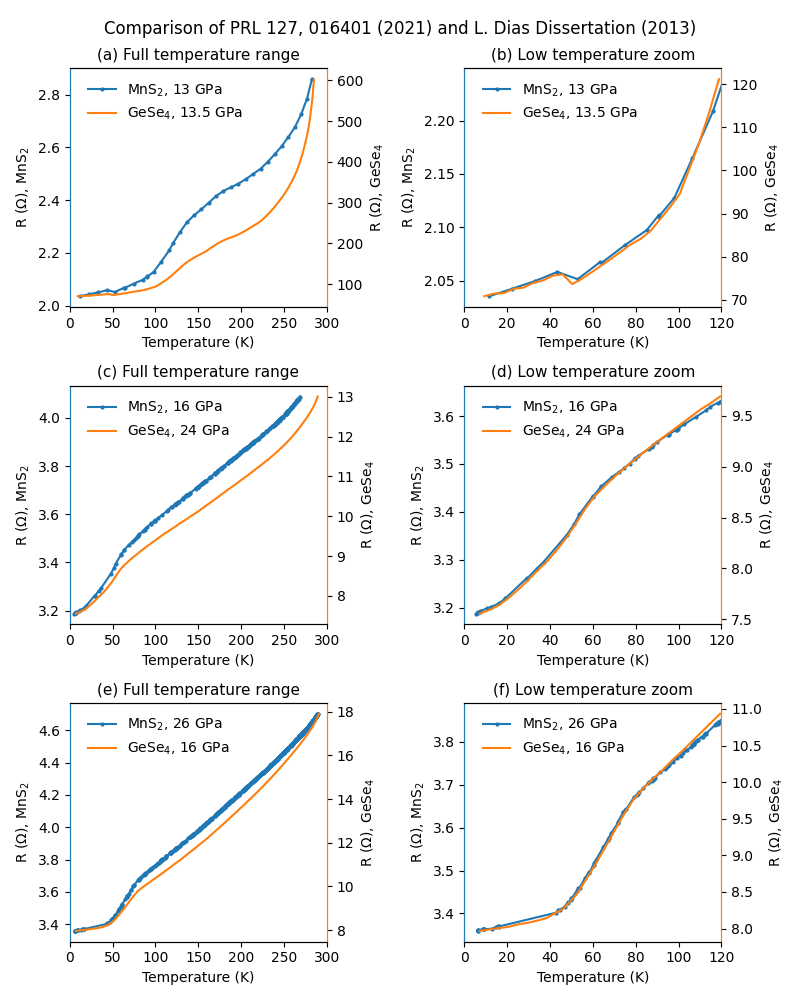

In [17]:
fig, ax = plt.subplots(3,2, figsize=(8, 10), layout='tight')
fig.suptitle("Comparison of PRL 127, 016401 (2021) and L. Dias Dissertation (2013)", fontsize=12)

T_low = 120
frame = 3

layout = (
    (
        {
            'panel': 'a',
            'MnS2_pressure': '13',
            'GeSe4_pressure': '13.5',
            'T_cutoff': 300
        },
        {
            'panel': 'b',
            'MnS2_pressure': '13',
            'GeSe4_pressure': '13.5',
            'T_cutoff': T_low + frame
        }
    ),
    (
        {
            'panel': 'c',
            'MnS2_pressure': '16',
            'GeSe4_pressure': '24',
            'T_cutoff': 300
        },
        {
            'panel': 'd',
            'MnS2_pressure': '16',
            'GeSe4_pressure': '24',
            'T_cutoff': T_low + frame
        }
    ),
    (
        {
            'panel': 'e',
            'MnS2_pressure': '26',
            'GeSe4_pressure': '16',
            'T_cutoff': 300
        },
        {
            'panel': 'f',
            'MnS2_pressure': '26',
            'GeSe4_pressure': '16',
            'T_cutoff': T_low + frame
        }
    )
)

for row in range(3):
    for column in range(2):
        subfig = layout[row][column]
        MnS2_pressure = subfig['MnS2_pressure']
        GeSe4_pressure = subfig['GeSe4_pressure']
        T_cutoff = subfig['T_cutoff']
        panel = subfig['panel']
        
        if panel in ('a', 'c', 'e'):
            ax[row][column].set_xlim(0, 300)
        else:
            ax[row][column].set_xlim(0, T_low)
        
        T = MnS2_dict[MnS2_pressure].Temp
        R = MnS2_dict[MnS2_pressure].R
        mask = T < T_cutoff
        ax[row][column].plot(
            T[mask],
            R[mask],
            '-o',
            markersize=2,
            label=f'MnS$_2$, {MnS2_pressure} GPa')

        ax2 = ax[row][column].twinx()

        T = GeSe4_dict[GeSe4_pressure].Temp
        R = GeSe4_dict[GeSe4_pressure].R
        mask = T < T_cutoff
        ax2.plot(
            T[mask],
            R[mask],
            color='tab:orange',
            label=f'GeSe$_4$, {GeSe4_pressure} GPa')

        ax[row][column].spines['left'].set_color('tab:blue')
        ax[row][column].spines['right'].set_color('tab:orange')
        # ax[row][column].yaxis.label.set_color('tab:blue')
        # ax[row][column].tick_params(axis='y', colors='tab:blue')

        ax2.spines['left'].set_color('tab:blue')
        ax2.spines['right'].set_color('tab:orange')
        # ax2.yaxis.label.set_color('tab:orange')
        # ax2.tick_params(axis='y', colors='tab:orange')

        ax[row][column].set_xlabel('Temperature (K)')
        ax[row][column].set_ylabel('R ($\Omega$), MnS$_2$')
        ax2.set_ylabel('R ($\Omega$), GeSe$_4$')
        ax[row][column].legend(loc=(0.05, 0.85), frameon=False)
        ax2.legend(loc=(0.05, 0.75), frameon=False)

        ax[row][column].set_title(
            f'({panel}) ' + 'Full temperature range'
            if
            panel in ('a', 'c', 'e')
            else
            f'({panel}) ' + 'Low temperature zoom',
            fontsize=11
        )
        
        # Print out the axis limits so that I can use the same limits
        # in the higher resolution extraction plots in notebook 06.
        if panel == 'b':
            print('For panel b:')
            print(f'Left y-axis limits: {ax[row][column].get_ylim()}')
            print(f'Right y-axis limits: {ax2.get_ylim()}')
        
plt.savefig('../MnS2_figures/MnS2_GeSe4_comparison.pdf')